## Exercise 5.8: Racetrack (programming) 
Consider driving a race car around a turn like those shown in Figure 5.5. You want to go as fast as possible, but not so fast as to run off the track. In our simplified racetrack, the car is at one of a discrete set of grid positions, the cells in the diagram. 
* The velocity is also discrete, a number of grid cells moved horizontally and vertically per time step. 
* The actions are increments to the velocity components. Each may be changed by +1, −1, or 0 in one step, for a total of nine actions. 
* Both velocity components are restricted to be nonnegative and less than 5, and they cannot both be zero except at the starting line. 
* Each episode begins in one of the randomly selected start states with both velocity components zero and ends when the car crosses the finish line. 
* The rewards are −1 for each step until the car crosses the finish line. 
* If the car hits the track boundary, it is moved back to a random position on the starting line, both velocity components are reduced to zero, and the episode continues. 
* Before updating the car’s location at each time step, check to see if the projected path of the car intersects the track boundary. If it intersects the finish line, the episode ends; if it intersects anywhere else, the car is considered to have hit the track boundary and is sent back to the starting line. 
* To make the task more challenging, with probability 0.1 at each time step the velocity increments are both zero, independently of the intended increments. 

Apply a Monte Carlo control method to this task to compute the optimal policy from each starting state. Exhibit several trajectories following the optimal policy (but turn the noise off for these trajectories).

<img src="racetrack.png" width="600">

In [1]:
from numpy import genfromtxt
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import os

CELL_TYPE_WALL = 0
CELL_TYPE_TRACK = 1
CELL_TYPE_GOAL = 2
CELL_TYPE_START = 3

class RaceTrack:
    def __init__(self, track, min_vel=0, max_vel=5):
        self.track = track
        self.wall_cells = np.argwhere(track == CELL_TYPE_WALL).tolist()
        self.goal_cells = np.argwhere(track == CELL_TYPE_GOAL).tolist()
        self.start_cells = np.argwhere(track == CELL_TYPE_START).tolist()
        self.min_vel = min_vel
        self.max_vel = max_vel
    
    @classmethod
    def from_csv(cls, file_path):
        
        file_path = os.path.join(os.getcwd(), file_path)
        
        track = genfromtxt(file_path, delimiter=',')
        
        # Flip the y-axis coordinates
        track = np.flip(track, axis=0)

        return cls(track) 
    
    def possible_actions(self, state):
        actions = [[a_y, a_x] for a_y in range(-1, 2) for a_x in range(-1, 2)]
        legal_actions = []

        _, _, v_y, v_x = state

        # Discard illegal actions
        for a in actions:
            a_y, a_x = a
            # Cannot go above speed limit in any x direction
            if v_x + a_x < self.min_vel or v_x + a_x > self.max_vel:
                continue
            # Cannot go above speed limit in any y direction
            if v_y + a_y < self.min_vel or v_y + a_y > self.max_vel:
                continue
            # Cannot noop
            if v_x + a_x == 0 and v_y + a_y == 0:
                continue
            legal_actions.append(a)
        return legal_actions
    
    def random_start_state(self):
        start_cell_idx = np.random.choice(len(self.start_cells))
        start_state = np.array(self.start_cells[start_cell_idx] + [0, 0])
        return start_state
    
    def apply_action(self, state, action):
        y_coord, x_coord, y_vel, x_vel = state
        a_y, a_x = action

        next_y_vel = y_vel + a_y
        next_x_vel = x_vel + a_x
        next_y_coord = y_coord + next_y_vel
        next_x_coord = x_coord + next_x_vel

        path = self.projected_path(
            (y_coord, x_coord), (next_y_vel, next_x_vel))

        if self.crossed_finish_line(path):
        #if self.crossed_finish_line([[next_y_coord, next_x_coord]]):
            return np.array([next_y_coord, next_x_coord, next_y_vel, next_x_vel]), 0, True
        #if self.crossed_track_boundary(path):
        if self.crossed_track_boundary([[next_y_coord, next_x_coord]]):
            return self.random_start_state(), -1, False

        return np.array([next_y_coord, next_x_coord, next_y_vel, next_x_vel]), -1, False
        
    def projected_path(self, state, speed):
        # TODO: Should we only consider end state directly?
        y_coord, x_coord = state
        y_vel, x_vel = speed

        new_y_coord = y_coord + y_vel
        new_x_coord = x_coord + x_vel

        path = []
        for dy in range(min(y_coord, new_y_coord), max(y_coord, new_y_coord) + 1):
            for dx in range(min(x_coord, new_x_coord), max(x_coord, new_x_coord) + 1):
                path.append([dy, dx])
        return path
        
    def crossed_track_boundary(self, projected_path):
        for cell in projected_path:
            y, x = cell
            if y < 0 or y >= self.track.shape[0] or x < 0 or x >= self.track.shape[1] or cell in self.wall_cells:
                return True
        return False

    def crossed_finish_line(self, projected_path):
        for cell in projected_path:
            if cell in self.goal_cells:
                return True
        return False
        
    def draw_episode(self, S, A, R): 
        colors = ['black', 'white', 'yellow', 'red']
        
        print(S)
        
        y_t = [s[1] for s in S]
        x_t = [s[0] for s in S]
        
        plt.figure(figsize=(10,10))
        plt.imshow(self.track, cmap=ListedColormap(colors), origin='lower',interpolation='none')
        
        def rect(pos, edgecolor='k', facecolor='none'):
            r = plt.Rectangle(pos, 1, 1, facecolor=facecolor,
                              edgecolor=edgecolor, linewidth=2)
            plt.gca().add_patch(r)

        for i in range(self.track.shape[0]):
            for j in range(self.track.shape[1]):
                rect((j-0.5, i-0.5))
        
        plt.plot(np.asarray(y_t), np.asarray(x_t),'o-')
        #plt.scatter(y_t[-1], x_t[-1], color='red', s=50)
        
#         fig=plt.figure(figsize=(10,10))
#         im = plt.imshow(self.track, cmap=ListedColormap(colors),
#                         origin='lower', interpolation='none')
        
#         def init():
#             im.set_data(self.track)
#             return [im]
            
#         def animate(i):
#             a = im.get_array()
            
        
        

        

#         

#         if path:
#             for cell in path:
#                 rect((cell[1]-0.5, cell[0]-0.5), edgecolor='g')

#         if car_cell:
#             rect((car_cell[1]-0.5, car_cell[0]-0.5),
#                  edgecolor='g', facecolor='g')

        plt.gca().invert_yaxis()
        #return im
        

In [2]:
rt = RaceTrack.from_csv("../racetracks/map1.csv")

In [3]:
path = rt.projected_path((6,8),(-2,2))
path

[[4, 8], [4, 9], [4, 10], [5, 8], [5, 9], [5, 10], [6, 8], [6, 9], [6, 10]]

In [4]:
import random
import math
from collections import defaultdict

class OnPolicyMonteCarloAgent:
    def __init__(self, track, gamma=0.25, n_episodes=100000, eps=0.9):
        self.track = track
        self.gamma = gamma
        self.n_episodes = n_episodes
        self.eps = eps

        # Initialize Q values and C values
        y_range = track.track.shape[0]
        x_range = track.track.shape[1]
        yvel_range = track.max_vel - track.min_vel + 1
        xvel_range = track.max_vel - track.min_vel + 1
        yacc_range = 3  # -1, 0, +1
        xacc_range = 3  # -1, 0, +1

        # Initialize state-action values
        self.Q = np.zeros((y_range, x_range, yvel_range,
                           xvel_range, yacc_range, xacc_range))

        # Initialize rewards dictionary
        self.R = defaultdict(list)

        # Initial Policy
        # For each state: assign equal probability of selecting each valid action from the state
        self.pi = np.zeros(self.Q.shape, dtype=float)
        for y_coord in range(self.Q.shape[0]):
            for x_coord in range(self.Q.shape[1]):
                for y_vel in range(track.min_vel, track.max_vel + 1):
                    for x_vel in range(track.min_vel, track.max_vel + 1):
                        valid_actions = self.track.possible_actions(
                            (y_coord, x_coord, y_vel, x_vel))
                        for y_acc, x_acc in valid_actions:
                            self.pi[y_coord, x_coord, y_vel, x_vel,
                                    y_acc, x_acc] = 1/len(valid_actions)
                        
    def sample_random_action(self, state):
        # Sample action according to our eps-greedy policy
        # Ensure that probabilities we sample from sum to 1
        y_coord, x_coord, y_vel, x_vel = state

        actionprobs = self.pi[y_coord, x_coord, y_vel, x_vel]
        total_prob = np.sum(actionprobs)
        if not math.isclose(total_prob, 1, abs_tol=0.01):
            print(
                'Action probabilities must sum to 1.0, but summed to {}, state: {}, actionprobs: {}'.format(total_prob, state, self.pi[tuple(state)]))
            sys.exit(1)

        linear_idx = np.random.choice(
            actionprobs.size, p=actionprobs.ravel())
        a = np.unravel_index(linear_idx, actionprobs.shape)
        # In case the value is greater than the max allowed action we need to translate it back into
        # negative coordinates
        a = tuple(acc if acc <= 1 else 1 - acc for acc in a)
        return a
    
    def greedy_action(self, state):
        # Find greedy action according to state-action values Q
        Q_state = self.Q[tuple(state)].copy()
        if not (Q_state == 0).all():
            Q_state[Q_state == 0] = np.nan
        a = np.unravel_index(np.nanargmax(Q_state, axis=None), Q_state.shape)
        # In case the value is greater than the max allowed action we need to translate it back into
        # negative coordinates
        a = tuple(acc if acc <= 1 else 1 - acc for acc in a)
        return a
            
    def generate_episode(self, pi, policy_type="eps_greedy"):
        S = []
        A = []
        R = []

        # Select the initial state randomly
        start_state = self.track.random_start_state()
        S.append(start_state)

        terminated = False
        t = 0
        while not terminated:
            St = S[t]

            if t % 10000 == 0:
                print("Step: {}".format(t))
            
            if policy_type == "eps_greedy":
                a = self.sample_random_action(St)
            elif policy_type == "greedy":
                a = self.greedy_action(St)
            else:
                print("Unknown policy_type {} in generate_episode. Must be either `greedy` or `eps_greedy`")
                sys.exit(1)
            A.append(a)

            next_state, reward, terminated = self.track.apply_action(St, a)

            R.append(reward)
            S.append(next_state)
            t += 1

            # time.sleep(1)
        print("Terminated after {} steps".format(t))
        return S, A, R
    
    def policy_iteration(self):
        policy_stable = False
        it = 0
        while True:
            if self.n_episodes is not None and it > self.n_episodes:
                break
            elif self.n_episodes is None and policy_stable:
                break
            
            print('Iteration {}'.format(it))

            # (a) Generate an episode using pi
            S, A, R = self.generate_episode(self.pi)

            visited = set()

            # (b) Iterate over s,a pairs and update rewards and q-values
            old_Q = self.Q.copy()
            for t in range(len(S)-2):
                St, At, Rt = S[t], A[t], R[t]

                state_action_key = tuple(St.tolist() + list(At))

                # Skip to next step if we have aldready encountered this state, action pair
                if state_action_key in visited:
                    continue

                visited.add(state_action_key)

                # Calculate return that follows the first occurence of St, At
                G = 0
                for dt in range(len(S)-2, t-1, -1):
                    G = self.gamma * G + R[dt]

                self.R[state_action_key].append(G)
                self.Q[state_action_key] = np.average(self.R[state_action_key])

            # Q-diff: Credit to Joakim Blach Andersen
            Q_diff = abs(old_Q - self.Q)
            print('Q-diff: {}'.format(np.max(Q_diff)))

            # (c) Iterate over all states s and update the eps-greedy policy
            for t in range(len(S)-2):
                y, x, y_vel, x_vel = S[t]

                possible_actions = self.track.possible_actions(S[t])
                for a in possible_actions:
                    a_y, a_x = a

                    self.pi[y, x, y_vel, x_vel, a_y, a_x] = self.eps / \
                        len(possible_actions)

                # Get index of best action
                a_ys, a_xs = tuple(zip(*possible_actions))
                actionvals = self.Q[y, x, y_vel,
                                    x_vel, a_ys, a_xs]
                a_max_idx = np.argmax(actionvals)
                a_max_y, a_max_x = a_ys[a_max_idx], a_xs[a_max_idx]

                self.pi[y, x, y_vel, x_vel, a_max_y, a_max_x] += 1 - self.eps

                actionprobs = self.pi[y, x, y_vel, x_vel]
                total_prob = np.sum(actionprobs)
                if not math.isclose(total_prob, 1, abs_tol=0.01):
                    print(
                        'Action probabilities must sum to 1.0, but summed to {}, state: {}, actionprobs: {}'.format(total_prob, s, self.pi[y, x, y_vel, x_vel]))
                    sys.exit(1)
            
            # Check if convergence in case no number of episodes is set to 0
            if np.allclose(old_Q, self.Q, atol=0.05):
                print("Policy iteration converged after {} episodes".format(it))
                policy_stable = True

            # Counter and update epsilon
            self.eps = 1/(math.sqrt(it+1.1))
            it += 1

In [9]:
agent = OnPolicyMonteCarloAgent(rt, n_episodes=1000, eps=0.5, gamma=0.9)

In [10]:
agent.policy_iteration()

Iteration 0
Step: 0
Terminated after 47 steps
Q-diff: 9.921448327887212
Iteration 1
Step: 0
Terminated after 2484 steps
Q-diff: 9.999999999999995
Iteration 2
Step: 0
Terminated after 1710 steps
Q-diff: 9.999999999999995
Iteration 3
Step: 0
Terminated after 3132 steps
Q-diff: 9.999999999999995
Iteration 4
Step: 0
Terminated after 7049 steps
Q-diff: 9.999999999999995
Iteration 5
Step: 0
Terminated after 164 steps
Q-diff: 9.999999410727073
Iteration 6
Step: 0
Terminated after 2861 steps
Q-diff: 9.999999999999995
Iteration 7
Step: 0
Terminated after 2800 steps
Q-diff: 9.999999999999995
Iteration 8
Step: 0
Terminated after 2853 steps
Q-diff: 9.999999999999995
Iteration 9
Step: 0
Terminated after 4990 steps
Q-diff: 9.999999999999995
Iteration 10
Step: 0
Terminated after 134 steps
Q-diff: 9.999960132765215
Iteration 11
Step: 0
Terminated after 147 steps
Q-diff: 9.999897095698547
Iteration 12
Step: 0
Terminated after 176 steps
Q-diff: 9.999999718152587
Iteration 13
Step: 0
Terminated after 990

Terminated after 76 steps
Q-diff: 9.912720364319124
Iteration 136
Step: 0
Terminated after 127 steps
Q-diff: 9.999595162339773
Iteration 137
Step: 0
Terminated after 72 steps
Q-diff: 9.892247363356944
Iteration 138
Step: 0
Terminated after 15 steps
Q-diff: 0.0900777947600293
Iteration 139
Step: 0
Terminated after 58 steps
Q-diff: 9.942735831029779
Iteration 140
Step: 0
Terminated after 16 steps
Q-diff: 0.1339286884761286
Iteration 141
Step: 0
Terminated after 38 steps
Q-diff: 0.2819022358205885
Iteration 142
Step: 0
Terminated after 64 steps
Q-diff: 9.690968456173676
Iteration 143
Step: 0
Terminated after 12 steps
Q-diff: 0.07744783941007771
Iteration 144
Step: 0
Terminated after 60 steps
Q-diff: 9.749684449500679
Iteration 145
Step: 0
Terminated after 14 steps
Q-diff: 0.131884930151287
Iteration 146
Step: 0
Terminated after 14 steps
Q-diff: 0.04371449961515417
Policy iteration converged after 146 episodes
Iteration 147
Step: 0
Terminated after 15 steps
Q-diff: 0.07336216817667118
Iter

Terminated after 40 steps
Q-diff: 0.0692671440488013
Iteration 251
Step: 0
Terminated after 12 steps
Q-diff: 0.019784883402196307
Policy iteration converged after 251 episodes
Iteration 252
Step: 0
Terminated after 16 steps
Q-diff: 0.022162857079710108
Policy iteration converged after 252 episodes
Iteration 253
Step: 0
Terminated after 15 steps
Q-diff: 0.25932781727456167
Iteration 254
Step: 0
Terminated after 56 steps
Q-diff: 9.749684449500679
Iteration 255
Step: 0
Terminated after 25 steps
Q-diff: 7.175704635190001
Iteration 256
Step: 0
Terminated after 33 steps
Q-diff: 1.0
Iteration 257
Step: 0
Terminated after 20 steps
Q-diff: 0.1872692858795224
Iteration 258
Step: 0
Terminated after 51 steps
Q-diff: 0.11989539104662583
Iteration 259
Step: 0
Terminated after 34 steps
Q-diff: 0.04306051766601193
Policy iteration converged after 259 episodes
Iteration 260
Step: 0
Terminated after 24 steps
Q-diff: 0.07729504389212849
Iteration 261
Step: 0
Terminated after 14 steps
Q-diff: 0.0145030826

Terminated after 20 steps
Q-diff: 0.10377142940130035
Iteration 344
Step: 0
Terminated after 19 steps
Q-diff: 0.014996326122238557
Policy iteration converged after 344 episodes
Iteration 345
Step: 0
Terminated after 37 steps
Q-diff: 0.23894466177866036
Iteration 346
Step: 0
Terminated after 41 steps
Q-diff: 9.528987130275377
Iteration 347
Step: 0
Terminated after 18 steps
Q-diff: 0.00940984428883418
Policy iteration converged after 347 episodes
Iteration 348
Step: 0
Terminated after 14 steps
Q-diff: 0.042942643286224325
Policy iteration converged after 348 episodes
Iteration 349
Step: 0
Terminated after 36 steps
Q-diff: 7.458134171671
Iteration 350
Step: 0
Terminated after 24 steps
Q-diff: 0.018870945963701757
Policy iteration converged after 350 episodes
Iteration 351
Step: 0
Terminated after 23 steps
Q-diff: 0.014267760575631172
Policy iteration converged after 351 episodes
Iteration 352
Step: 0
Terminated after 21 steps
Q-diff: 0.03811064058190894
Policy iteration converged after 35

Terminated after 14 steps
Q-diff: 0.0062987406481394
Policy iteration converged after 441 episodes
Iteration 442
Step: 0
Terminated after 50 steps
Q-diff: 9.01522909781639
Iteration 443
Step: 0
Terminated after 14 steps
Q-diff: 0.006179051659744417
Policy iteration converged after 443 episodes
Iteration 444
Step: 0
Terminated after 14 steps
Q-diff: 0.006120482449698983
Policy iteration converged after 444 episodes
Iteration 445
Step: 0
Terminated after 15 steps
Q-diff: 0.9154821263251494
Iteration 446
Step: 0
Terminated after 12 steps
Q-diff: 0.0067555643591790115
Policy iteration converged after 446 episodes
Iteration 447
Step: 0
Terminated after 14 steps
Q-diff: 0.006062742049230074
Policy iteration converged after 447 episodes
Iteration 448
Step: 0
Terminated after 23 steps
Q-diff: 1.11872012575065
Iteration 449
Step: 0
Terminated after 65 steps
Q-diff: 9.90302262702125
Iteration 450
Step: 0
Terminated after 14 steps
Q-diff: 0.05413540579152887
Iteration 451
Step: 0
Terminated after

Terminated after 25 steps
Q-diff: 0.16893282925872732
Iteration 554
Step: 0
Terminated after 33 steps
Q-diff: 1.9
Iteration 555
Step: 0
Terminated after 18 steps
Q-diff: 0.0057693235305418256
Policy iteration converged after 555 episodes
Iteration 556
Step: 0
Terminated after 29 steps
Q-diff: 0.07542389777349001
Iteration 557
Step: 0
Terminated after 38 steps
Q-diff: 0.4197882328136924
Iteration 558
Step: 0
Terminated after 16 steps
Q-diff: 0.00904435004014914
Policy iteration converged after 558 episodes
Iteration 559
Step: 0
Terminated after 28 steps
Q-diff: 7.7123207545039
Iteration 560
Step: 0
Terminated after 14 steps
Q-diff: 0.0041743328607619645
Policy iteration converged after 560 episodes
Iteration 561
Step: 0
Terminated after 26 steps
Q-diff: 0.0041474882764473975
Policy iteration converged after 561 episodes
Iteration 562
Step: 0
Terminated after 33 steps
Q-diff: 0.3952561692865668
Iteration 563
Step: 0
Terminated after 30 steps
Q-diff: 0.6863037736488273
Iteration 564
Step:

Q-diff: 0.43707382918117244
Iteration 647
Step: 0
Terminated after 12 steps
Q-diff: 0.003735094056128929
Policy iteration converged after 647 episodes
Iteration 648
Step: 0
Terminated after 33 steps
Q-diff: 8.49905364703001
Iteration 649
Step: 0
Terminated after 12 steps
Q-diff: 0.003712593489526128
Policy iteration converged after 649 episodes
Iteration 650
Step: 0
Terminated after 15 steps
Q-diff: 0.004368003727799774
Policy iteration converged after 650 episodes
Iteration 651
Step: 0
Terminated after 32 steps
Q-diff: 0.006977254168113234
Policy iteration converged after 651 episodes
Iteration 652
Step: 0
Terminated after 15 steps
Q-diff: 0.004328800248536879
Policy iteration converged after 652 episodes
Iteration 653
Step: 0
Terminated after 21 steps
Q-diff: 0.004420534010467492
Policy iteration converged after 653 episodes
Iteration 654
Step: 0
Terminated after 26 steps
Q-diff: 0.0036902956307303114
Policy iteration converged after 654 episodes
Iteration 655
Step: 0
Terminated afte

Iteration 756
Step: 0
Terminated after 17 steps
Q-diff: 0.30000000000000004
Iteration 757
Step: 0
Terminated after 15 steps
Q-diff: 0.0060952244370025
Policy iteration converged after 757 episodes
Iteration 758
Step: 0
Terminated after 28 steps
Q-diff: 0.004832774049763344
Policy iteration converged after 758 episodes
Iteration 759
Step: 0
Terminated after 12 steps
Q-diff: 0.0030922069368282123
Policy iteration converged after 759 episodes
Iteration 760
Step: 0
Terminated after 14 steps
Q-diff: 0.002658320239175893
Policy iteration converged after 760 episodes
Iteration 761
Step: 0
Terminated after 14 steps
Q-diff: 2.71
Iteration 762
Step: 0
Terminated after 16 steps
Q-diff: 0.007318389951718629
Policy iteration converged after 762 episodes
Iteration 763
Step: 0
Terminated after 23 steps
Q-diff: 0.0047303481713569795
Policy iteration converged after 763 episodes
Iteration 764
Step: 0
Terminated after 32 steps
Q-diff: 7.94108867905351
Iteration 765
Step: 0
Terminated after 34 steps
Q-di

Q-diff: 8.905810108684877
Iteration 868
Step: 0
Terminated after 26 steps
Q-diff: 0.18368568959760445
Iteration 869
Step: 0
Terminated after 24 steps
Q-diff: 0.0026310789102428345
Policy iteration converged after 869 episodes
Iteration 870
Step: 0
Terminated after 14 steps
Q-diff: 0.002184339581776662
Policy iteration converged after 870 episodes
Iteration 871
Step: 0
Terminated after 35 steps
Q-diff: 0.03947650848715689
Policy iteration converged after 871 episodes
Iteration 872
Step: 0
Terminated after 28 steps
Q-diff: 0.0029188196005325295
Policy iteration converged after 872 episodes
Iteration 873
Step: 0
Terminated after 12 steps
Q-diff: 0.0026069683168339353
Policy iteration converged after 873 episodes
Iteration 874
Step: 0
Terminated after 15 steps
Q-diff: 0.004792071185667268
Policy iteration converged after 874 episodes
Iteration 875
Step: 0
Terminated after 30 steps
Q-diff: 8.49905364703001
Iteration 876
Step: 0
Terminated after 14 steps
Q-diff: 3.439
Iteration 877
Step: 0
T

Terminated after 38 steps
Q-diff: 0.16542886455069628
Iteration 977
Step: 0
Terminated after 16 steps
Q-diff: 0.003863105418872692
Policy iteration converged after 977 episodes
Iteration 978
Step: 0
Terminated after 68 steps
Q-diff: 9.690968456173676
Iteration 979
Step: 0
Terminated after 33 steps
Q-diff: 7.458134171671
Iteration 980
Step: 0
Terminated after 17 steps
Q-diff: 0.0030481715745800386
Policy iteration converged after 980 episodes
Iteration 981
Step: 0
Terminated after 26 steps
Q-diff: 0.04739154453723948
Policy iteration converged after 981 episodes
Iteration 982
Step: 0
Terminated after 41 steps
Q-diff: 9.72187161055631
Iteration 983
Step: 0
Terminated after 15 steps
Q-diff: 0.002629202667963071
Policy iteration converged after 983 episodes
Iteration 984
Step: 0
Terminated after 18 steps
Q-diff: 0.002114665916467473
Policy iteration converged after 984 episodes
Iteration 985
Step: 0
Terminated after 17 steps
Q-diff: 0.003271382755862362
Policy iteration converged after 985

In [11]:
%matplotlib inline
from IPython import display
import time

S, A, R = agent.generate_episode(agent.pi, policy_type="greedy")

Step: 0
Terminated after 14 steps


[array([0, 5, 0, 0]), array([1, 5, 1, 0]), array([3, 5, 2, 0]), array([4, 5, 1, 0]), array([6, 5, 2, 0]), array([8, 6, 2, 1]), array([11,  6,  3,  0]), array([13,  7,  2,  1]), array([16,  7,  3,  0]), array([19,  7,  3,  0]), array([22,  7,  3,  0]), array([24,  8,  2,  1]), array([26, 10,  2,  2]), array([28, 13,  2,  3]), array([30, 16,  2,  3])]


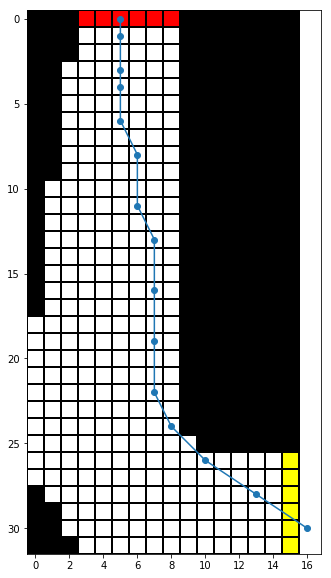

In [12]:
rt.draw_episode(S, A, R)

In [111]:
Q_joakim = np.load(os.path.join(os.getcwd(), 'Q_matrix_Joakim.csv.npy'))

In [98]:
Q_troels = np.load(os.path.join(os.getcwd(), 'Q_matrix_Troels.csv.npy'))

In [ ]:
class OffPolicyMonteCarloAgent:
    def __init__(self, track, gamma=0.25, n_episodes=100000, eps=0.9):
        self.track = track
        self.gamma = gamma
        self.n_episodes = n_episodes
        self.eps = eps

        # Initialize Q values and C values
        y_range = track.track.shape[0]
        x_range = track.track.shape[1]
        yvel_range = track.max_vel - track.min_vel + 1
        xvel_range = track.max_vel - track.min_vel + 1
        yacc_range = 3  # -1, 0, +1
        xacc_range = 3  # -1, 0, +1

        # Initialize state-action values
        self.Q = np.zeros((y_range, x_range, yvel_range,
                           xvel_range, yacc_range, xacc_range))
        
        self.C = np.zeros_like(self.Q)

        # Initial Policy
        # For each state: assign equal probability of selecting each valid action from the state
        self.pi = np.zeros((y_range, x_range, yvel_range, xvel_range), dtype=object)
        for y_coord in range(self.Q.shape[0]):
            for x_coord in range(self.Q.shape[1]):
                for y_vel in range(track.min_vel, track.max_vel + 1):
                    for x_vel in range(track.min_vel, track.max_vel + 1):
                        valid_actions = self.track.possible_actions(
                            (y_coord, x_coord, y_vel, x_vel))
                        
                        self.pi[y_coord, x_coord, y_vel, x_vel] = np.random.choice(valid_actions)
                        
    def policy_iteration(self):
        policy_stable = False
        it = 0
        while True:
            if self.n_episodes is not None and it > self.n_episodes:
                break
            elif self.n_episodes is None and policy_stable:
                break
            
            print('Iteration {}'.format(it))
            
            # b ← any soft policy

            # (a) Generate an episode using pi
            S, A, R = self.generate_episode(b)

            G = 0
            W = 1
            for dt in range(len(S)-2, 0, -1):
                St, At, Rt = S[dt], A[dt], R[dt]
                state_action_key = tuple(St.tolist() + list(At))

                G = self.gamma * G + R[dt]
                self.C[state_action_key] = self.C[state_action_key] + W
                self.Q[state_action_key] = self.Q[state_action_key] + W/self.C[state_action_key] * (G - self.Q[state_action_key])
                self.pi[tuple(St)] = self.greedy_action(St)

                if At is not self.pi[tuple(St)]:
                    break

                W = W/b[state_action_key]
        